In [1]:
import matplotlib.pyplot as plt
import os, os.path
import glob
import pickle
import numpy as np
from numpy.polynomial import Polynomial
from scipy import ndimage, signal, interpolate
#import matplotlib
#matplotlib.use('PDF')
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014
from galpy.util import bovy_conversion, save_pickles, bovy_coords, bovy_plot
#import pal5_util_old as pal5_util
import gd1_util
#import custom_stripping_df
import seaborn as sns
import astropy.units as u
from galpy import potential
%pylab inline
from matplotlib import cm, pyplot
from gd1_util_MWhaloshape import lb_to_phi12
from galpy.actionAngle import estimateBIsochrone, actionAngleIsochroneApprox



Populating the interactive namespace from numpy and matplotlib


In [2]:
#Jeremy and Jo's model, end of the leading arm
#NOTE: phi1 for this point gives -92 deg, this is a point along the orbit and not a point on the stream
ra=122.968652691887
dec=-9.969068202814725
d = 9.468134830338986
pmra= -1.0277792637560275
pmdec= -7.485334923475567
vlos = 303.54730262016966

lb=bovy_coords.radec_to_lb(np.radians(ra),np.radians(dec))
phi12=lb_to_phi12(lb[0],lb[1])

print (np.degrees(phi12[0])-360.,np.degrees(phi12[1]))

end_coord=[ra,dec,d,pmra,pmdec,vlos]

-92.10954738227082 -3.527698085246242


### determine the time at which the progenitor was at phi1 = -40 deg to get the phase space of the progenitor

In [3]:
tend=np.linspace(-0.031,-0.0316,20)  # these times were obtained by trial and error
diff=np.empty(len(tend))
for ii in range(len(tend)):
    obs= Orbit(end_coord,radec=True,ro=8.,vo=220.,solarmotion=[-11.1,24.,7.25])
    ts=np.linspace(0.,tend[ii],500)/bovy_conversion.time_in_Gyr(220.,8.)
    obs.integrate(ts,MWPotential2014)

    ra1=obs.ra(ts[-1])
    dec1=obs.dec(ts[-1])

    lb=bovy_coords.radec_to_lb(np.radians(ra1),np.radians(dec1))
    phi1=np.degrees(lb_to_phi12(lb[0],lb[1])[0])
    if phi1 > 180. : 
        phi1-=360.
    diff[ii]=np.abs(phi1-(-40.))
    
tpro=tend[argmin(diff)]
    
print (tpro)

-0.03153684210526316


### Integrate end coord to the progenitor's location

In [4]:
obs= Orbit(end_coord,radec=True,ro=8.,vo=220.,solarmotion=[-11.1,24.,7.25])
ts=np.linspace(0.,tpro,1000)/bovy_conversion.time_in_Gyr(220.,8.)
obs.integrate(ts,MWPotential2014)

ll=obs.ll(ts[-1])
bb=obs.bb(ts[-1])
dist=obs.dist(ts[-1])
pmll=obs.pmll(ts[-1])
pmbb=obs.pmbb(ts[-1])
vlos=obs.vlos(ts[-1])

gd1_prog_lb=[ll,bb,dist,pmll,pmbb,vlos]
print (gd1_prog_lb)

[188.04928416766532, 51.848594007807456, 7.559027173643999, 12.260258757214746, -5.140630283489461, 7.162732847549563]


In [ ]:
print (obs.pmdec(ts[-1]))

### Find isochrone parameter

In [5]:
prog_orb=Orbit(gd1_prog_lb,lb=True,ro=8.,vo=220.,solarmotion=[-11.1,24.,7.25])
orb_galpy=prog_orb._orb.vxvv

ts1=np.linspace(0.,-3.4,1000)/bovy_conversion.time_in_Gyr(220.,8.)
prog_orb.integrate(ts1,MWPotential2014)

print (estimateBIsochrone(MWPotential2014,prog_orb.R(ts1)/8.,prog_orb.z(ts1))/8.)


[0.07302462 0.30884214 0.45459102]


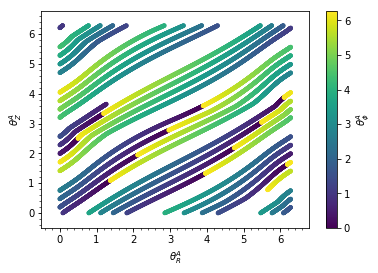

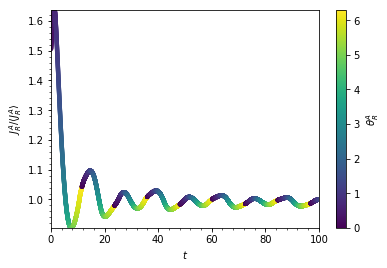

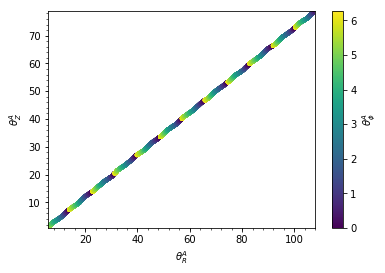

In [6]:
#Try different b following the above estimate and visually select based on linearity and quickness of convergence 

aAIA= actionAngleIsochroneApprox(pot=MWPotential2014,b=0.4)
aAIA(*orb_galpy)

aAIA.plot(*orb_galpy,type='araz')

aAIA.plot(*orb_galpy,type='jr')

aAIA.plot(*orb_galpy,type='araz',deperiod=True)

In [15]:
import gd1_util

#from above b=0.4 looks good
Tstream=2.3
sdf_leading=gd1_util.setup_gd1model(age=Tstream,new_orb_lb=gd1_prog_lb,isob=0.4,sigv=0.35)
sdf_trailing=gd1_util.setup_gd1model(leading=False,age=Tstream,new_orb_lb=gd1_prog_lb,isob=0.4,sigv=0.35)


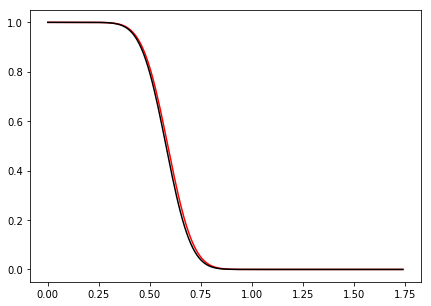

In [16]:
import numpy
import matplotlib.pyplot as plt

apar=numpy.arange(0.,1.75,0.01)

dens_lead= [sdf_leading._density_par(a) for a in apar]
dens_trail= [sdf_trailing._density_par(a) for a in apar]

plt.figure(figsize=(7,5))
plt.plot(apar,dens_lead,c='r')
plt.plot(apar,dens_trail,c='k')
plt.show()

In [17]:
#sample points from the stream

lb_sample_trailing= sdf_trailing.sample(n=3000,lb=True)
lb_sample_leading= sdf_leading.sample(n=3000,lb=True)


phi12_sample_trailing=lb_to_phi12(lb_sample_trailing[0],lb_sample_trailing[1],degree=True)
phi12_sample_leading=lb_to_phi12(lb_sample_leading[0],lb_sample_leading[1],degree=True)

for ii in range(len(phi12_sample_trailing)):
    if phi12_sample_trailing[:,0][ii]>180.:
        phi12_sample_trailing[:,0][ii]-=360.
        
    if phi12_sample_leading[:,0][ii]>180.:
        phi12_sample_leading[:,0][ii]-=360.



In [18]:
tracklb_trailing=np.radians(sdf_trailing._interpolatedObsTrackLB[:,0]),np.radians(sdf_trailing._interpolatedObsTrackLB[:,1])
tracklb_leading=np.radians(sdf_leading._interpolatedObsTrackLB[:,0]),np.radians(sdf_leading._interpolatedObsTrackLB[:,1])

phi12_trail=np.degrees(lb_to_phi12(tracklb_trailing[0],tracklb_trailing[1]))
phi12_lead=np.degrees(lb_to_phi12(tracklb_leading[0],tracklb_leading[1]))

#print (np.degrees(phi12[0])-360.,np.degrees(phi12[1]))
for ii in range(len(phi12_trail)):
    if phi12_trail[:,0][ii]>180.:
        phi12_trail[:,0][ii]-=360.
        
for ii in range(len(phi12_lead)):
    if phi12_lead[:,0][ii]>180.:
        phi12_lead[:,0][ii]-=360.

print (phi12_lead)
                          

[[ -39.75098517   -0.13106234]
 [ -39.839314     -0.13088071]
 [ -39.92765453   -0.13071283]
 ...
 [-108.63510476   -4.51434971]
 [-108.67880059   -4.52054453]
 [-108.72245683   -4.52673926]]


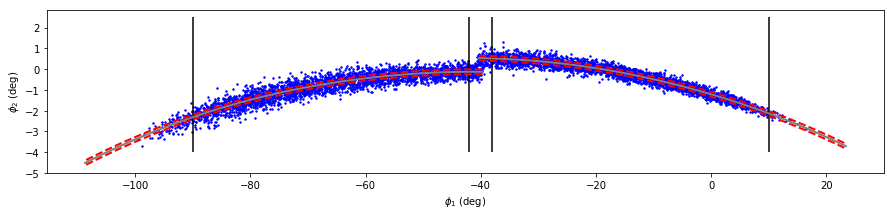

In [19]:
#overplot GD1 stars selected by APW and AB
GD1_obs=np.loadtxt('APW_AB_GD1_phi12.dat')

plt.figure(figsize=(15,3))
plt.plot(phi12_trail[:,0],phi12_trail[:,1],lw=2,c='gray')
plt.plot(phi12_lead[:,0],phi12_lead[:,1],lw=2,c='gray')

plt.plot(phi12_trail[:,0],phi12_trail[:,1]+(7./60.),ls='--',lw=2,c='r')
plt.plot(phi12_trail[:,0],phi12_trail[:,1]-(7./60.),ls='--',lw=2,c='r')
plt.plot(phi12_lead[:,0],phi12_lead[:,1]+(7./60.),ls='--',lw=2,c='r')
plt.plot(phi12_lead[:,0],phi12_lead[:,1]-(7./60.),ls='--',lw=2,c='r')

plt.scatter(phi12_sample_trailing[:,0],phi12_sample_trailing[:,1],s=2,c='b')
plt.scatter(phi12_sample_leading[:,0],phi12_sample_leading[:,1],s=2,c='b')

#plt.scatter(GD1_obs[:,0],GD1_obs[:,1],c='k',s=2,label='APW-AB-selection')
plt.vlines(-38.,-4,2.5)
plt.vlines(10.,-4,2.5)

plt.vlines(-90.,-4,2.5)
plt.vlines(-42.,-4,2.5)



plt.xlabel(r'$\phi_{1}$ (deg)')
plt.ylabel(r'$\phi_{2}$ (deg)')
#plt.xlim(-100.,20.)
#plt.ylim(-6.,4.)
#plt.legend(loc='upper right')
plt.show()

### Take both arms excluding 4 degrees around the progenitor at -40 deg. Bin in $1^{\circ} \phi_{1}$ bins. For each bin, compute mean $\phi_{2}$ of the track, subtract this mean from the $\phi_{2}$ of all the points in that bin.  Compute the std deviation of all these offset corrected $\phi_{2}$

In [12]:
bin_width=1.
phi1_trail_min=-38.
phi1_trail_max=10.

phi1_lead_min=-90.
phi1_lead_max=-42.

nbin_trail=int(-(-phi1_trail_max+phi1_trail_min)//bin_width) +1
nbin_lead=int(-(-phi1_lead_max+phi1_lead_min)//bin_width) +1

#print (nbin_trail, nbin_lead)

phi1_bin_trail_edges=np.linspace(phi1_trail_min,phi1_trail_max,nbin_trail)
phi1_bin_lead_edges=np.linspace(phi1_lead_min,phi1_lead_max,nbin_lead)

#print (phi1_bin_edges)

phi2_offset=[]


for ii in range(nbin_trail-1):
    phi2_mean = np.mean(phi12_trail[:,1][(phi1_bin_trail_edges[ii] < phi12_trail[:,0]) & ( phi12_trail[:,0] < phi1_bin_trail_edges[ii+1])])
    p2 = phi12_sample_trailing[:,1][(phi1_bin_trail_edges[ii] < phi12_sample_trailing[:,0]) & ( phi12_sample_trailing[:,0] < phi1_bin_trail_edges[ii+1])]
    p2-=phi2_mean
    for p in p2 :
        phi2_offset.append(p)
        
for ii in range(nbin_lead-1):
    phi2_mean = np.mean(phi12_lead[:,1][(phi1_bin_lead_edges[ii] < phi12_lead[:,0]) & ( phi12_lead[:,0] < phi1_bin_lead_edges[ii+1])])
    p2 = phi12_sample_leading[:,1][(phi1_bin_lead_edges[ii] < phi12_sample_leading[:,0]) & ( phi12_sample_leading[:,0] < phi1_bin_lead_edges[ii+1])]
    p2-=phi2_mean
    for p in p2 :
        phi2_offset.append(p)



Angular width 14.08 arcmins


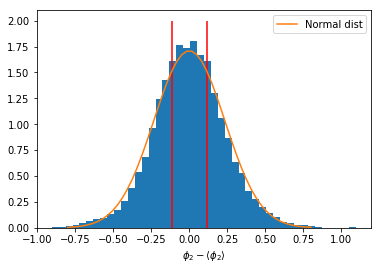

In [14]:
from scipy.stats import norm

phi2=np.linspace(-0.8,0.8,50)


print ("Angular width %.2f arcmins"%(np.std(phi2_offset)*60.))


plt.figure()
plt.hist(phi2_offset,bins='scott',density=True)
plt.plot(phi2,norm.pdf(phi2,scale=14./60.),label=r'Normal dist') #normal distribution with sigma = 14 arcmin
plt.vlines(7./60,0.,2.,color='r')
plt.vlines(-7./60,0.,2.,color='r')
plt.xlabel(r'$\phi_{2} - \langle\phi_{2}\rangle $')
plt.legend(loc='upper right')
plt.show()

13.518242655116843 23.490555780187627 0.26945790046395335 0.432771562215438


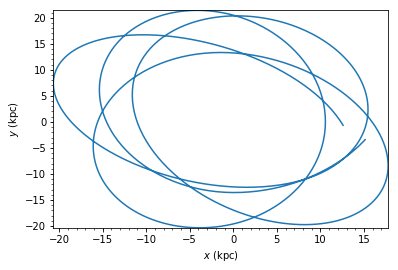

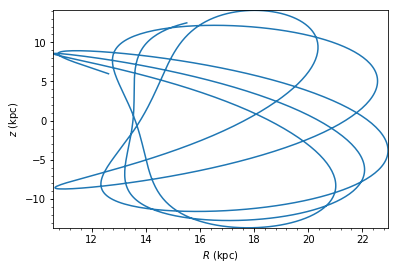

In [20]:
prog_orb=Orbit(gd1_prog_lb,lb=True,ro=8.,vo=220.,solarmotion=[-11.1,24.,7.25])

ts1=np.linspace(0.,-2.3,1000)/bovy_conversion.time_in_Gyr(220.,8.)
prog_orb.integrate(ts1,MWPotential2014)

prog_orb.plot(d1='x',d2='y')
prog_orb.plot(d1='R',d2='z')

print (prog_orb.rperi(),prog_orb.rap(),prog_orb.e(),prog_orb.Tr(use_physical=True))



In [ ]:
def parse_times(times,age,ro=8.,vo=220.):
    if 'sampling' in times:
        nsam= int(times.split('sampling')[0])
        print (nsam)
        return [float(ti)/bovy_conversion.time_in_Gyr(vo,ro)
                for ti in numpy.arange(1,nsam+1)/(nsam+1.)*age]
    return [float(ti)/bovy_conversion.time_in_Gyr(vo,ro)
            for ti in times.split(',')]
            
timpacts= parse_times('64sampling',9.,ro=8.,vo=220.)

#print (np.array(timpacts)*bovy_conversion.time_in_Gyr(220.,8.))


In [ ]:
orb_lb=[188.04928416766532, 51.848594007807456, 7.559027173643999, 12.260258757214746, -5.140630283489461, 7.162732847549563]
#isob=0.4

sdf=gd1_util.setup_gd1model(timpact=timpacts,hernquist=True,new_orb_lb=orb_lb,isob=0.4,age=3.4)

In [3]:
with open('gd1pepper_leading_Hernquist_td3.4_64sampling_progphi1-40.0_MW2014.pkl','rb') as savefile:
            sdf_pepper_lead= pickle.load(savefile,encoding='latin1')

        
with open('gd1pepper_trailing_Hernquist_td3.4_64sampling_progphi1-40.0_MW2014.pkl','rb') as savefile:
            sdf_pepper_trail= pickle.load(savefile,encoding='latin1')


0.0 1.9394333318881665
0.0 1.9695583226671936


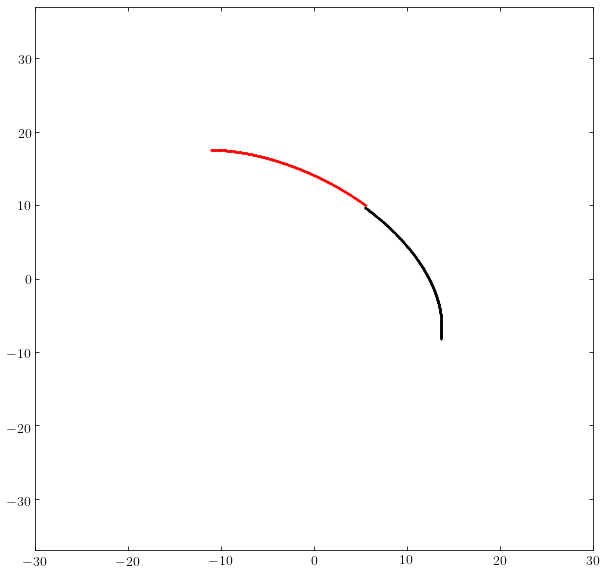

0.0 1.9091296860774138
0.0 1.9387839738755186


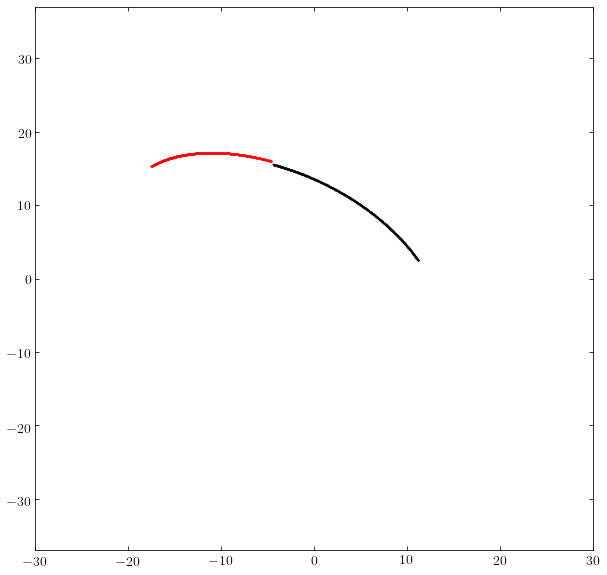

0.0 1.8788260402666612
0.0 1.9080096250838436


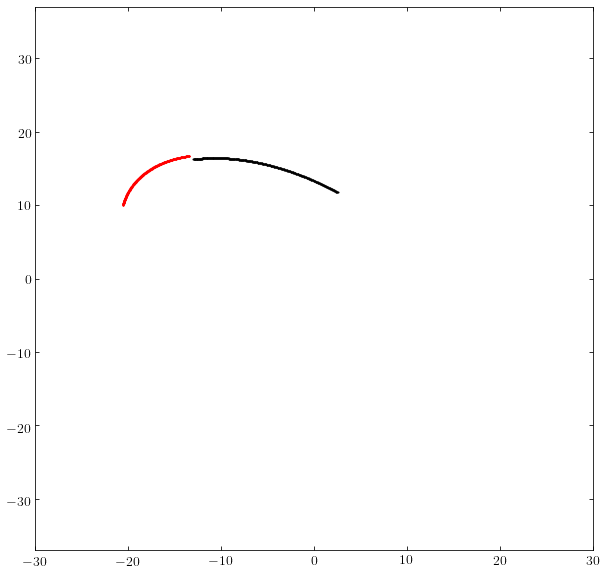

0.0 1.8485223944559086
0.0 1.877235276292169


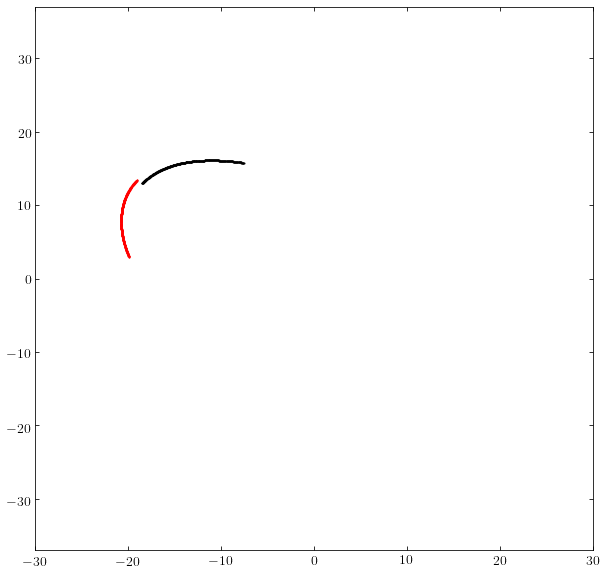

0.0 1.818218748645156
0.0 1.846460927500494


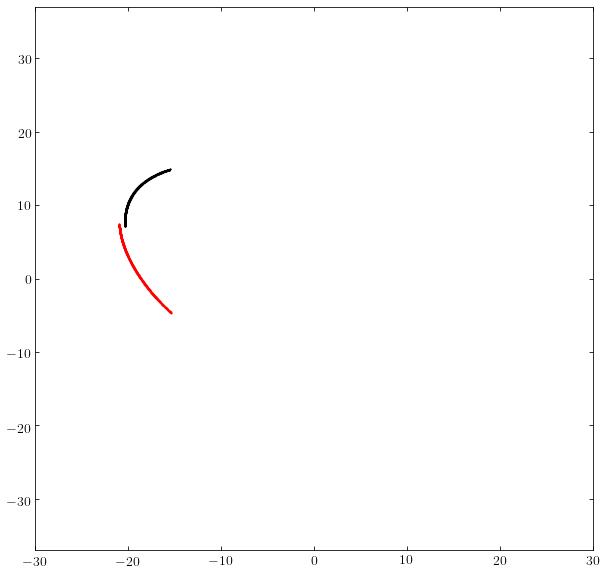

0.0 1.7879151028344036
0.0 1.8156865787088192


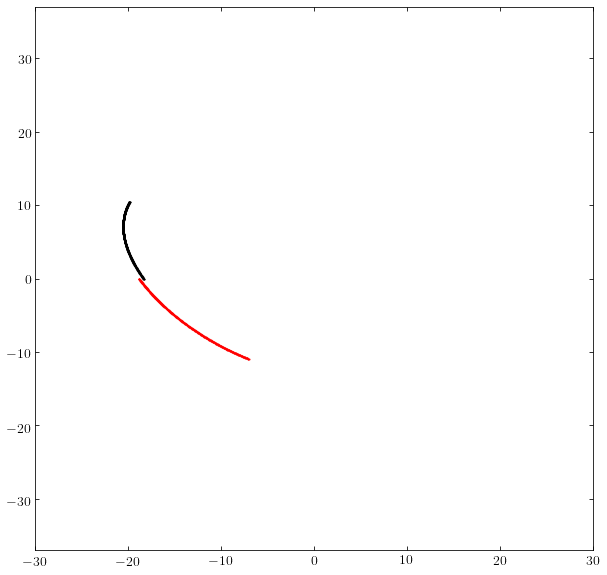

0.0 1.757611457023651
0.0 1.7849122299171443


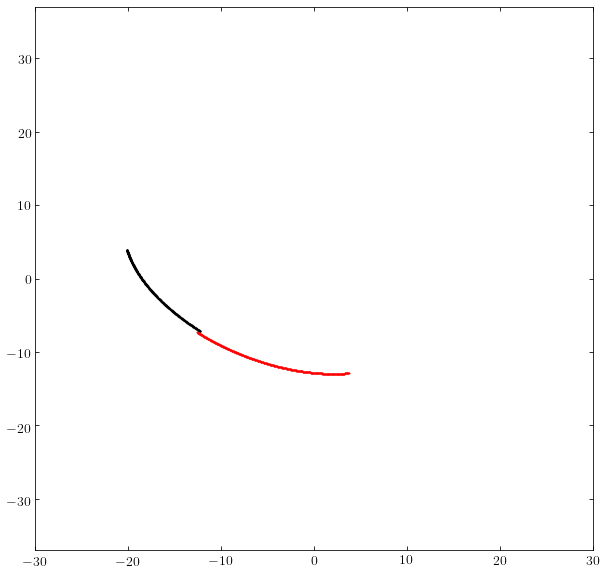

0.0 1.7273078112128983
0.0 1.7541378811254693


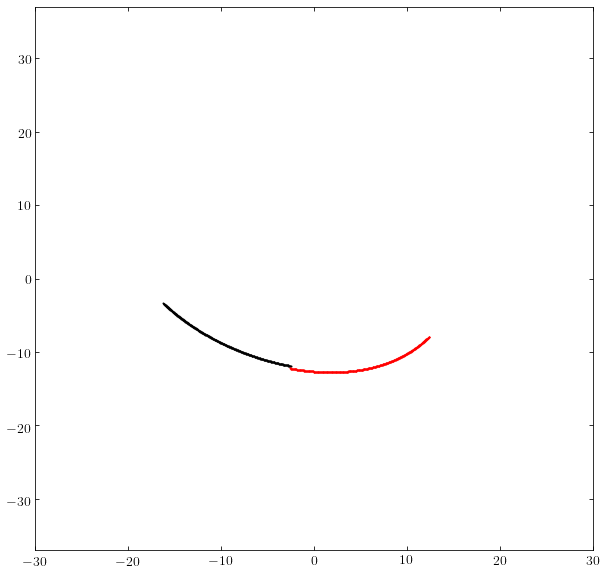

0.0 1.6970041654021457
0.0 1.7233635323337944


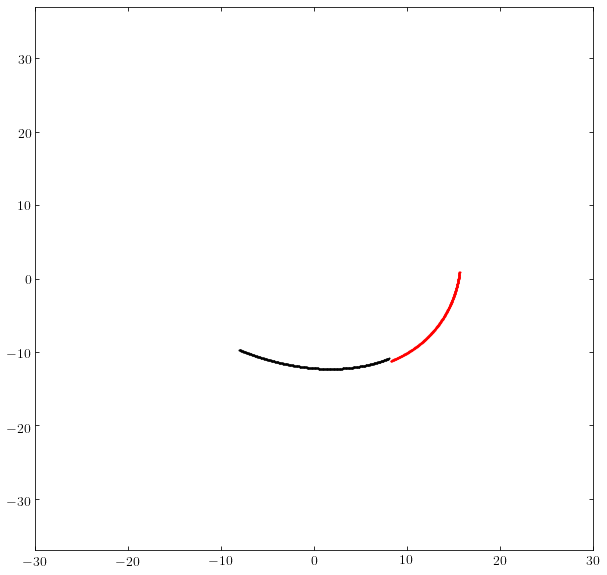

0.0 1.666700519591393
0.0 1.6925891835421196


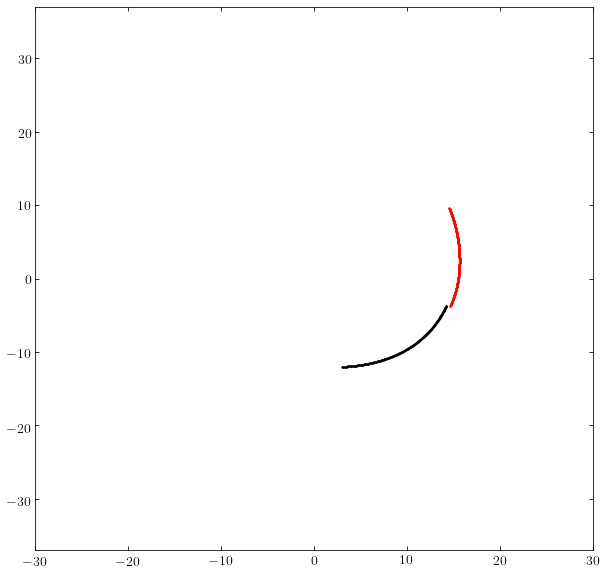

0.0 1.6363968737806405
0.0 1.6618148347504447


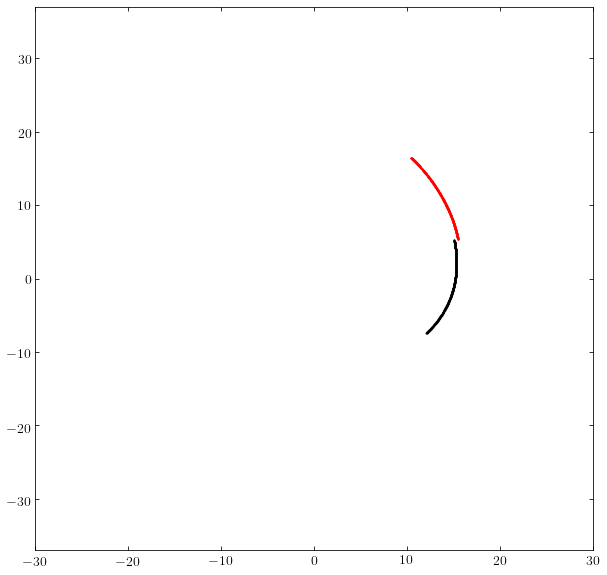

0.0 1.6060932279698878
0.0 1.6310404859587697


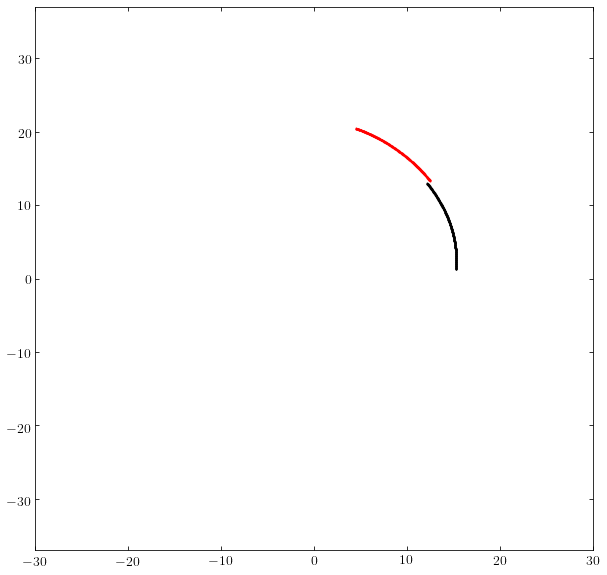

0.0 1.5757895821591352
0.0 1.6002661371670948


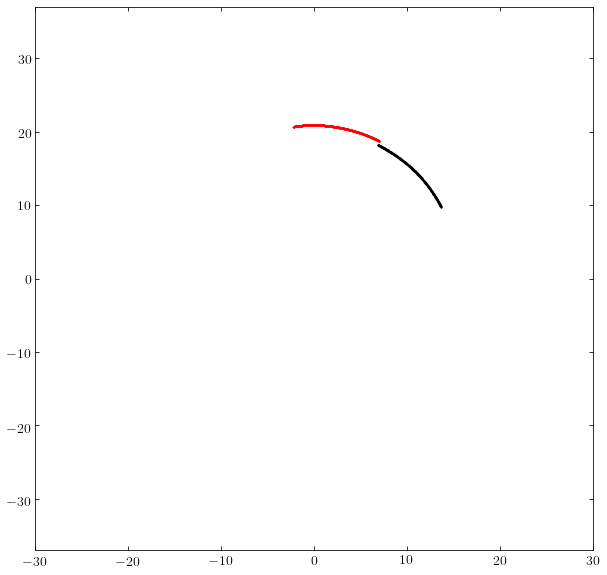

0.0 1.5454859363483826
0.0 1.5694917883754198


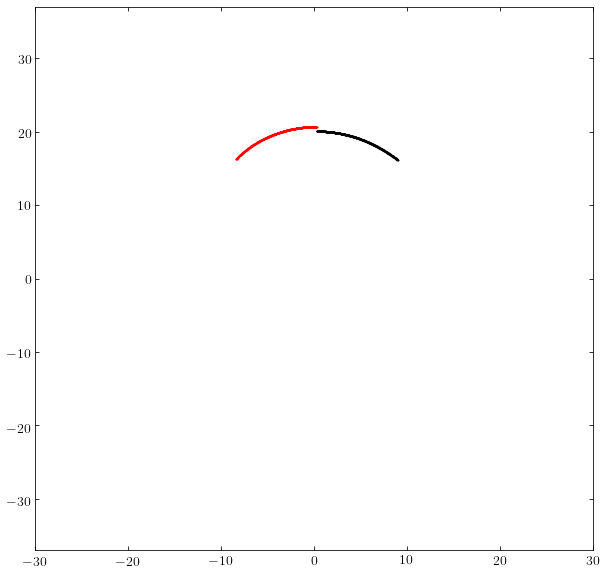

0.0 1.5151822905376302
0.0 1.5387174395837453


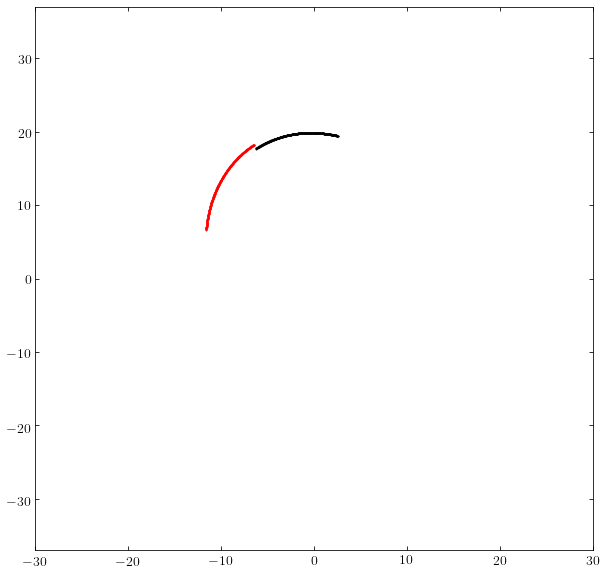

0.0 1.4848786447268776
0.0 1.5079430907920703


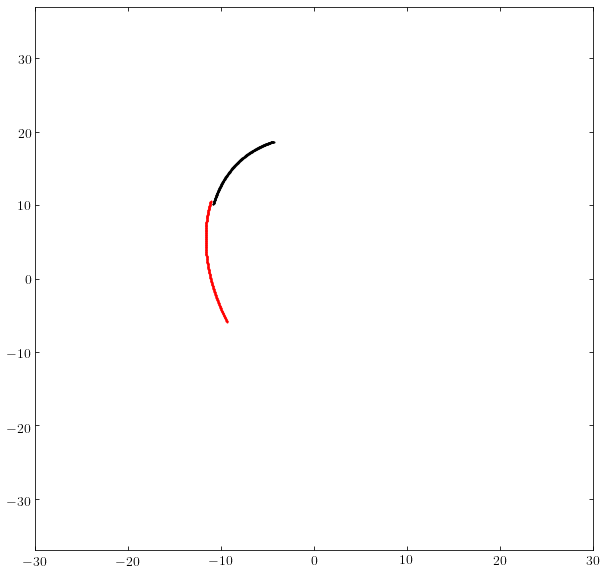

0.0 1.454574998916125
0.0 1.4771687420003954


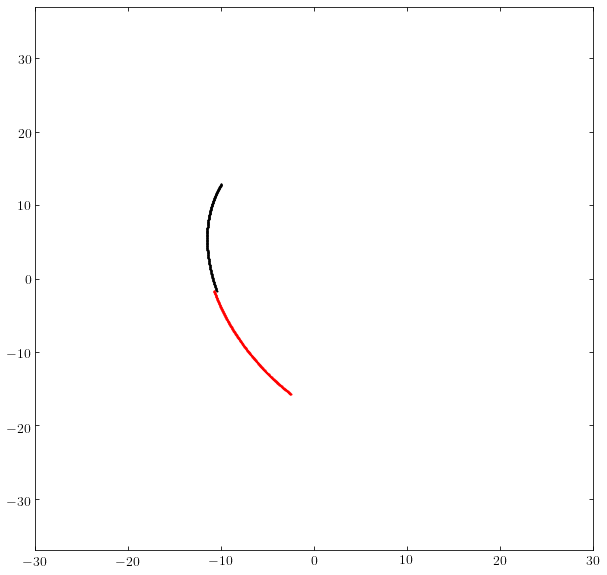

0.0 1.4242713531053723
0.0 1.4463943932087204


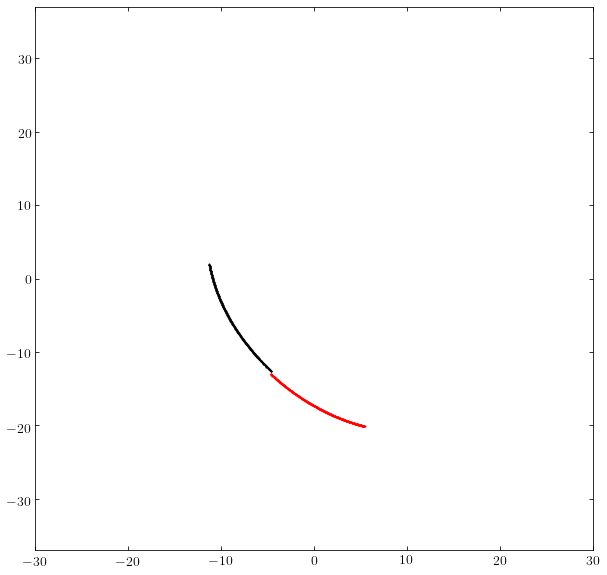

0.0 1.3939677072946197
0.0 1.4156200444170455


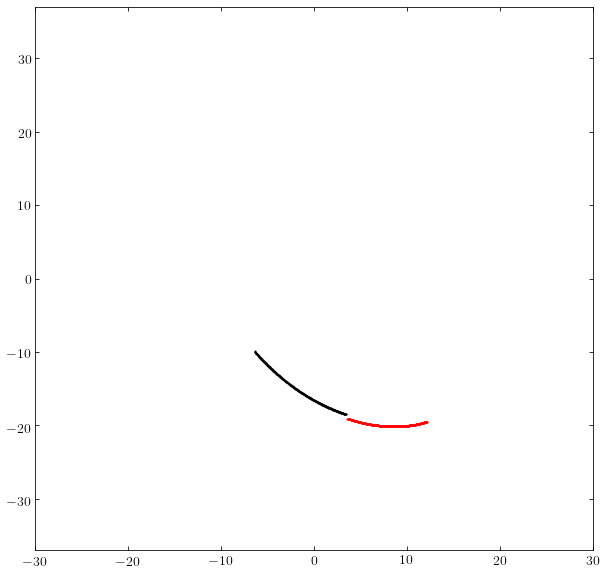

0.0 1.363664061483867
0.0 1.3848456956253705


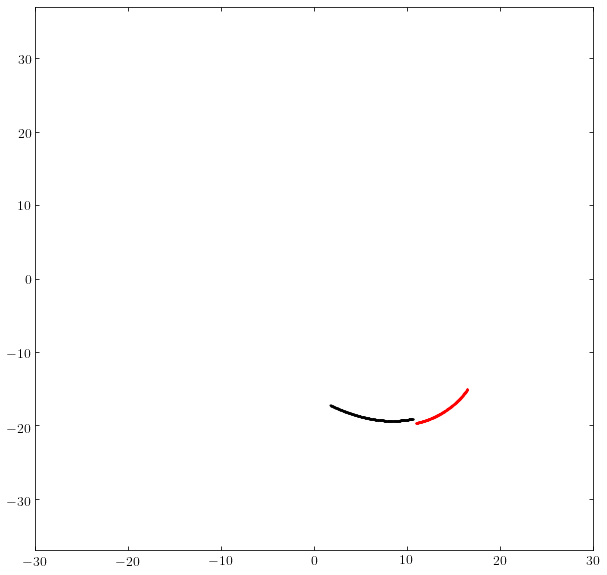

0.0 1.3333604156731145
0.0 1.3540713468336956


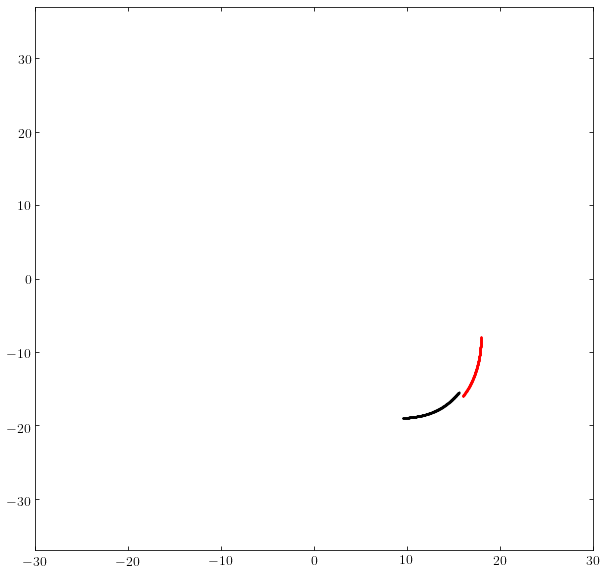

0.0 1.3030567698623619
0.0 1.3232969980420206


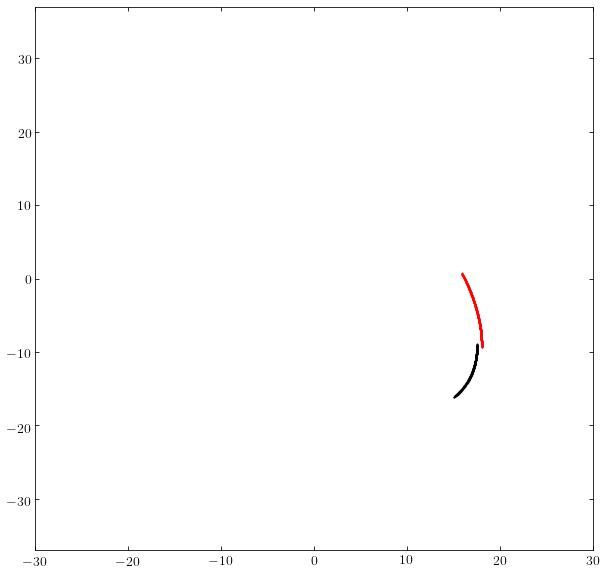

0.0 1.2727531240516092
0.0 1.2925226492503459


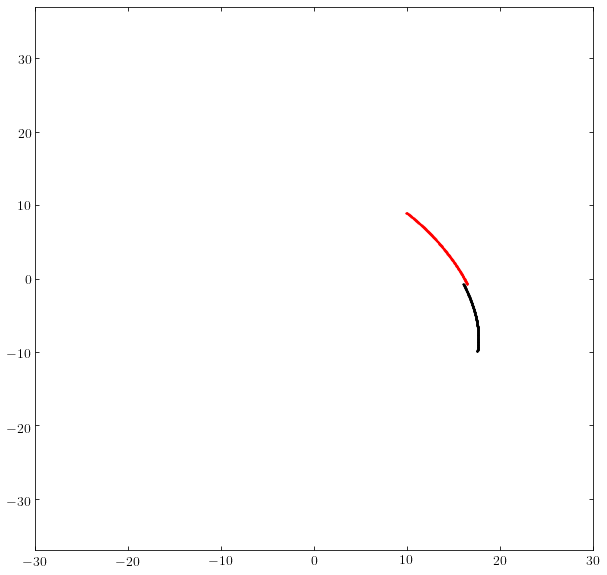

0.0 1.2424494782408568
0.0 1.261748300458671


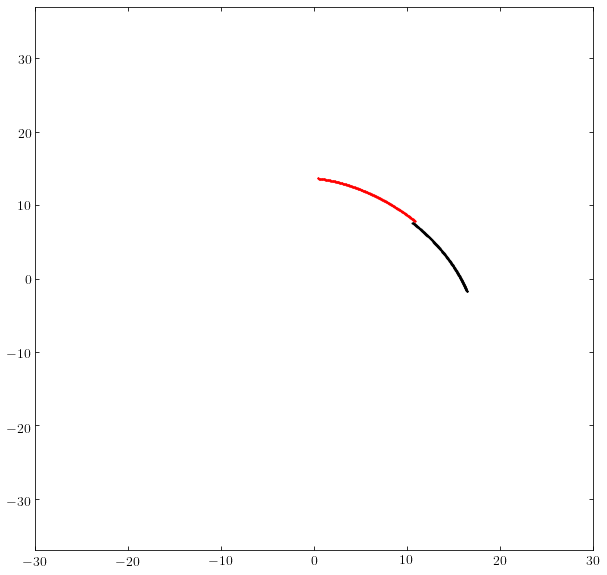

0.0 1.2121458324301042
0.0 1.230973951666996


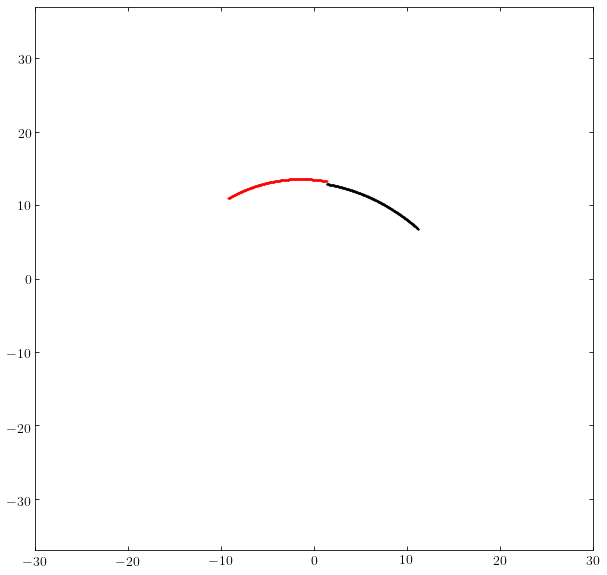

0.0 1.1818421866193516
0.0 1.2001996028753212


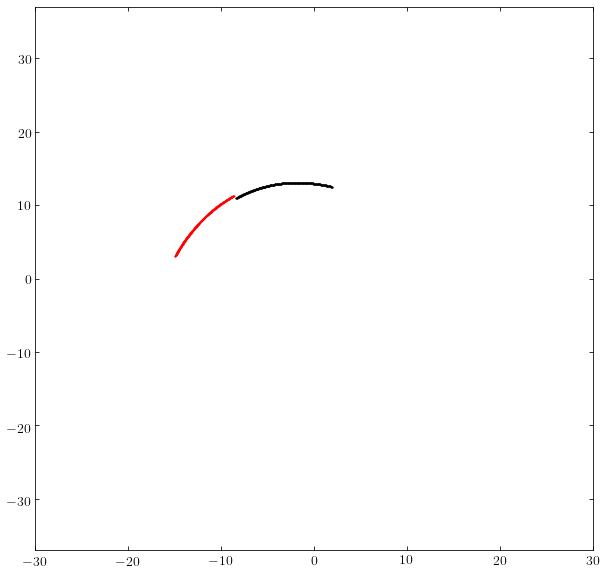

0.0 1.151538540808599
0.0 1.1694252540836463


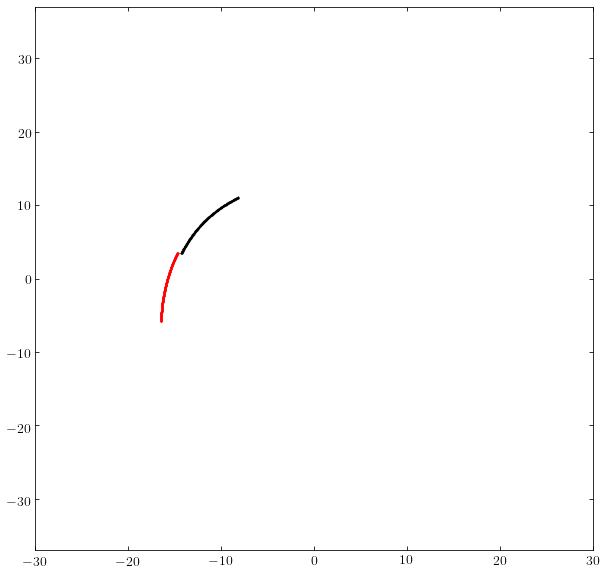

0.0 1.1212348949978463
0.0 1.1386509052919713


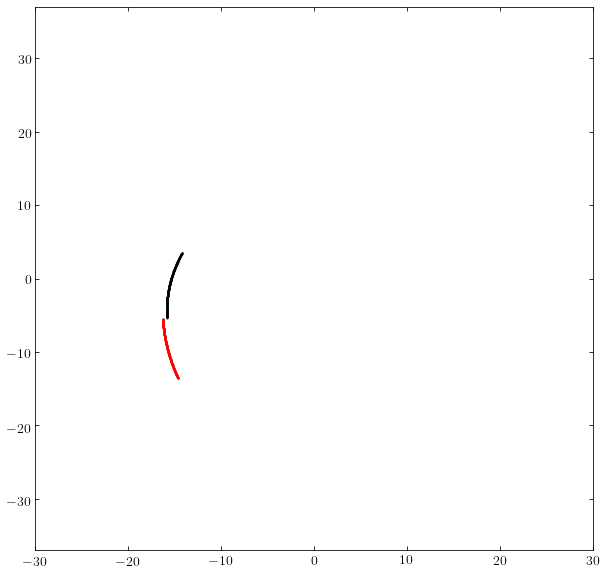

0.0 1.0909312491870937
0.0 1.1078765565002964


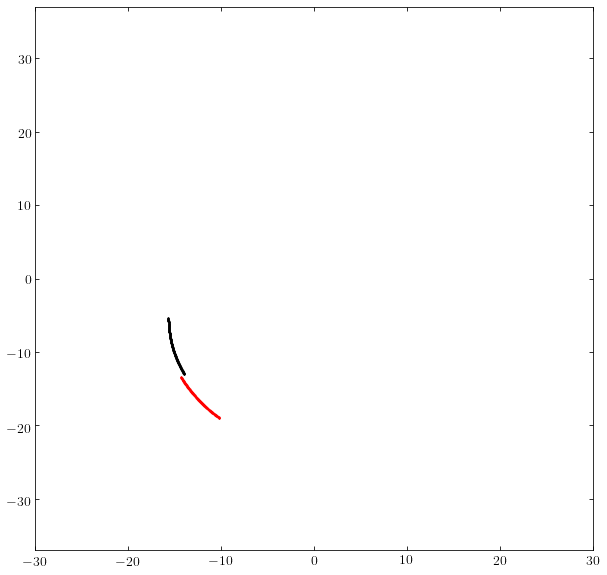

0.0 1.060627603376341
0.0 1.0771022077086216


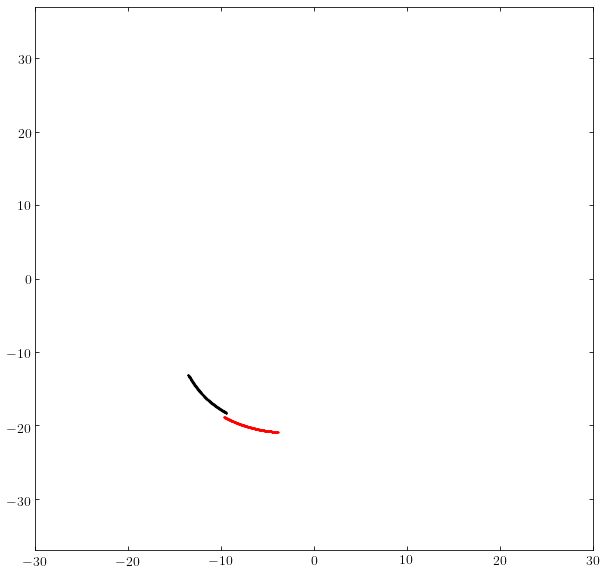

0.0 1.0303239575655885
0.0 1.0463278589169467


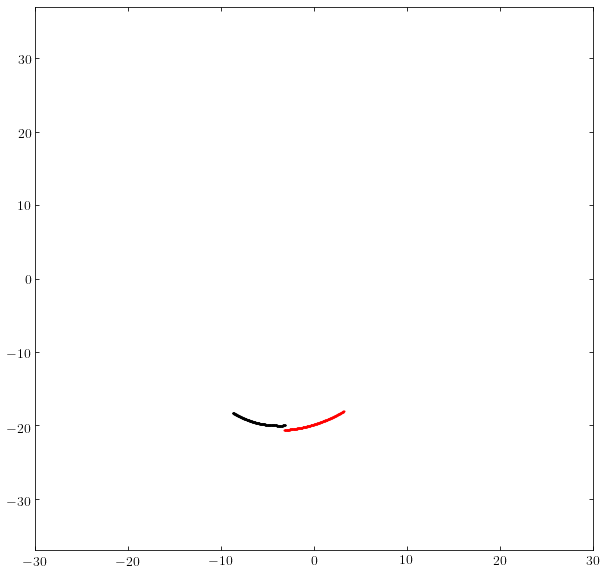

0.0 1.0000203117548359
0.0 1.0155535101252717


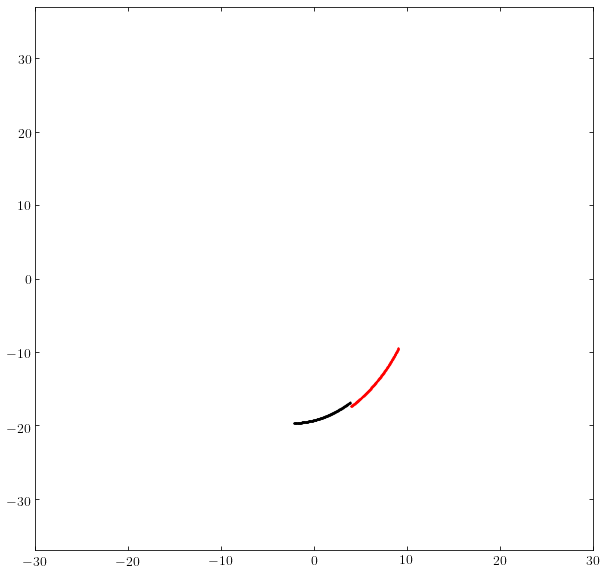

0.0 0.9697166659440833
0.0 0.9847791613335969


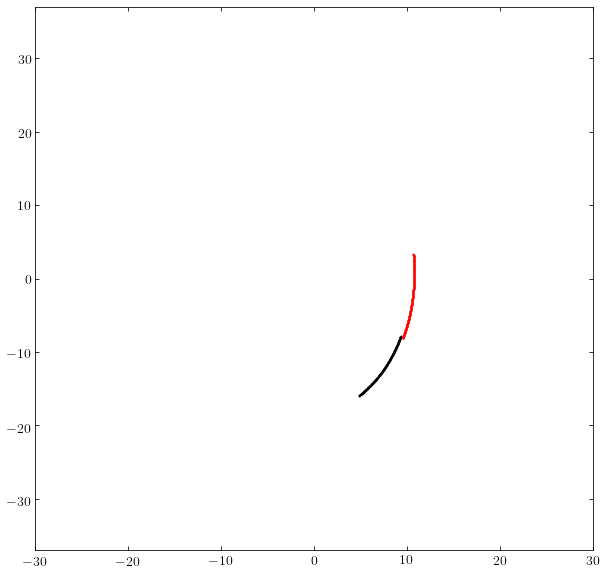

0.0 0.9394130201333306
0.0 0.9540048125419218


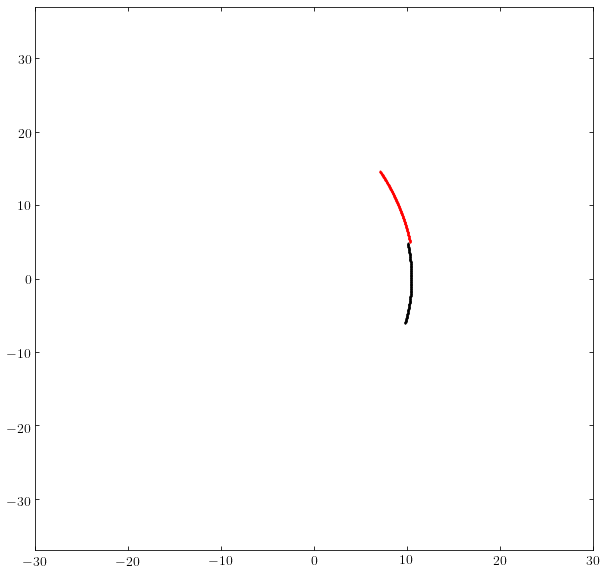

0.0 0.9091093743225781
0.0 0.9232304637502471


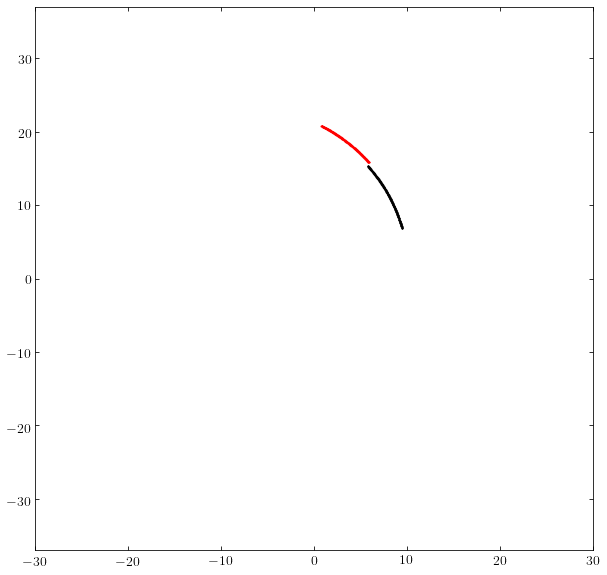

0.0 0.8788057285118255
0.0 0.8924561149585721


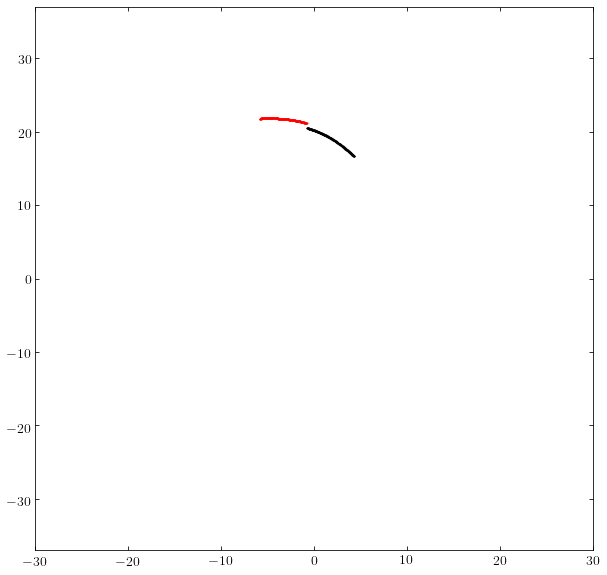

0.0 0.8485020827010731
0.0 0.8616817661668974


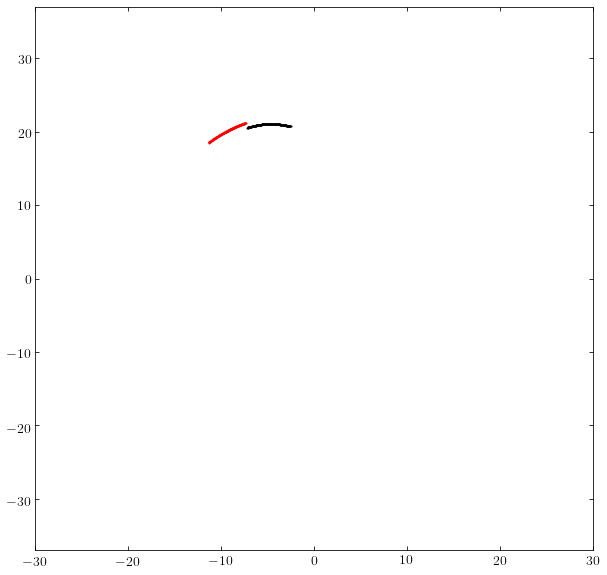

0.0 0.8181984368903203
0.0 0.8309074173752224


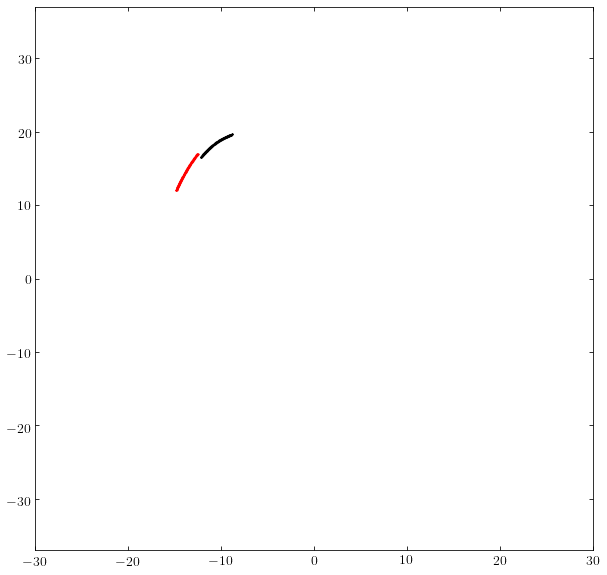

0.0 0.7878947910795676
0.0 0.8001330685835474


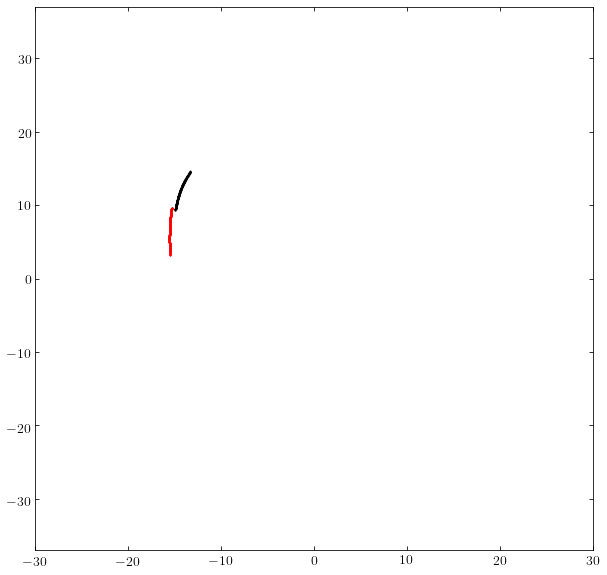

0.0 0.757591145268815
0.0 0.7693587197918724


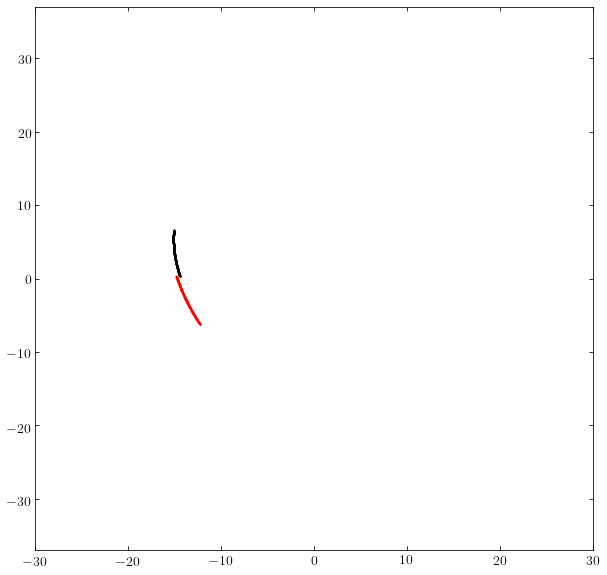

0.0 0.7272874994580627
0.0 0.7385843710001978


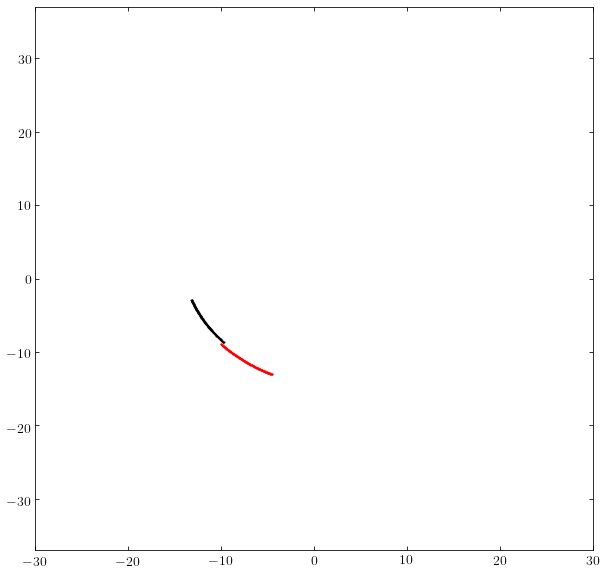

0.0 0.6969838536473097
0.0 0.7078100222085226


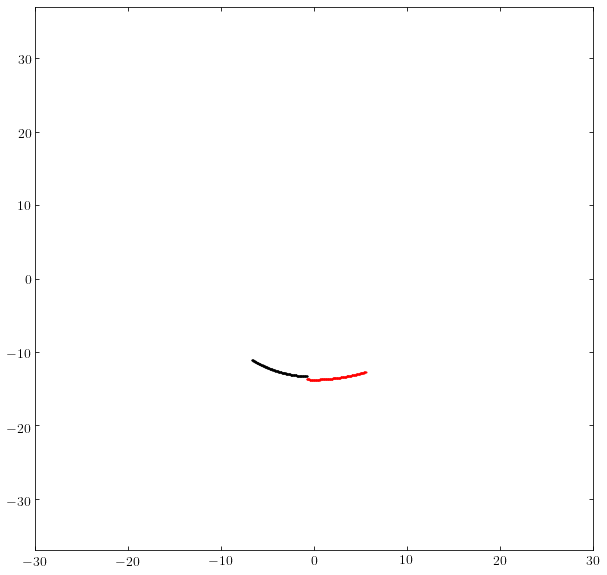

0.0 0.6666802078365573
0.0 0.677035673416848


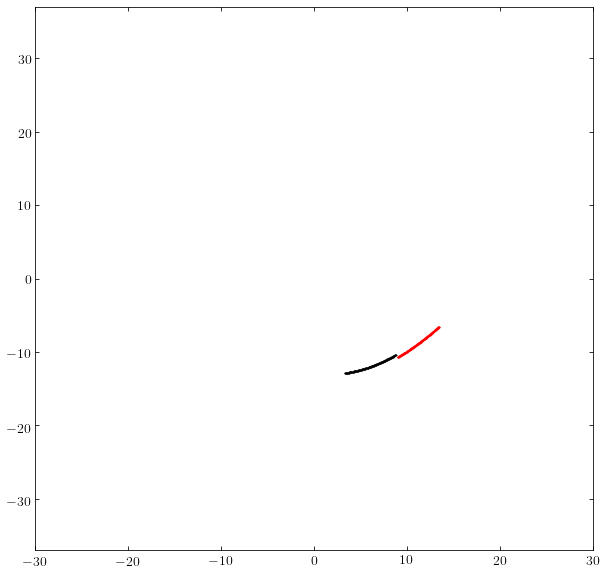

0.0 0.6363765620258046
0.0 0.6462613246251729


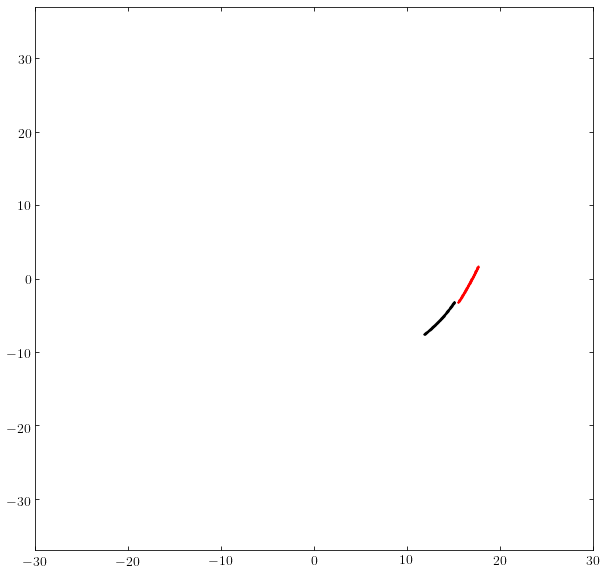

In [7]:
timpact1=sdf_pepper_trail._timpact

ro=8.
vo=220.

for kk in range(0,len(timpact1)-20): #time in reverse
    
    #print (timpact1[kk])
    x=[]
    y=[]
    z=[]
    
    x1=[]
    y1=[]
    z1=[]
    
    xyz_trail= sdf_pepper_trail._sgapdfs_coordtransform[timpact1[kk]]._kick_interpolatedObsTrackXY
    apar_trail=sdf_pepper_trail._sgapdfs_coordtransform[timpact1[kk]]._kick_interpolatedThetasTrack
    xyz_lead= sdf_pepper_lead._sgapdfs_coordtransform[timpact1[kk]]._kick_interpolatedObsTrackXY
    apar_lead=sdf_pepper_lead._sgapdfs_coordtransform[timpact1[kk]]._kick_interpolatedThetasTrack
    
    print (min(apar_trail),max(apar_trail))
    print (min(apar_lead),max(apar_lead))
           
    bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
    figsize(10,10)
        
       
    for ii in range(len(apar_trail)):
            x1.append(xyz_trail[:,0][ii])
            y1.append(xyz_trail[:,1][ii])
            z1.append(xyz_trail[:,2][ii])
            
    for jj in range(len(apar_lead)):
            x.append(xyz_lead[:,0][jj])
            y.append(xyz_lead[:,1][jj])
            z.append(xyz_lead[:,2][jj])
    
       
    plt.scatter(np.array(x)*ro,np.array(y)*ro,c='k',s=1)
    plt.scatter(np.array(x1)*ro,np.array(y1)*ro,c='r',s=1)
    plt.xlim(-30.,30.)
    plt.ylim(-37.,37.)
    plt.show()

In [ ]:
for ii in range(0,10,2) :
    print (ii)

In [43]:
print (0.365/2.*(9./1.5))

1.095
